# **Demand Forecasting system**


In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Initialize Spark session
spark = SparkSession.builder.appName("Demand_Forecasting_in_Retail").getOrCreate()

## **Part 1: Loading and cleaning data**

In [6]:
# Importing sales data
df_sales = spark.read.csv("Online Retail.csv",
                          header=True, inferSchema=True, sep=",")
df_sales.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [7]:
df_sales.count()

541909

Check and remove cancelled transactions

In [10]:
# Check the number of transactions
df_sales.select('InvoiceNo').distinct().count()

25900

In [11]:
# Check the number of cancelled transactions
canceled = df_sales.filter(df_sales['InvoiceNo'].startswith('C') == True)
canceled.select('InvoiceNo').distinct().count()

3836

In [12]:
# Remove cancelled transactions
df_sales = df_sales.filter(df_sales['InvoiceNo'].startswith('C') == False)

532621

Check and drop any records with null values

In [13]:
# Check missing values
df_sales.select([sf.count(sf.when(col(c).isNull(), c)).alias(c) \
                 for c in df_sales.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    134697|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [14]:
# Remove transactions with missing values
df_sales = df_sales.na.drop()

Exploring features and check for errors, outliers or irrelevant values


In [16]:
# 'Country' represents the name of the country where each customer resides.
# Check if any customer is assigned with more than one country
df_sales.groupBy('CustomerID').agg(sf.countDistinct('Country').alias('CountDistCountry'),
                                  sf.collect_set(col('Country')).alias('Countries'))\
                                .filter(col('CountDistCountry')>1).show(truncate=False)

+----------+----------------+------------------------+
|CustomerID|CountDistCountry|Countries               |
+----------+----------------+------------------------+
|12370     |2               |[Austria, Cyprus]       |
|12394     |2               |[Denmark, Belgium]      |
|12417     |2               |[Spain, Belgium]        |
|12422     |2               |[Australia, Switzerland]|
|12429     |2               |[Austria, Denmark]      |
|12431     |2               |[Australia, Belgium]    |
|12455     |2               |[Spain, Cyprus]         |
|12457     |2               |[Switzerland, Cyprus]   |
+----------+----------------+------------------------+



In [17]:
# Find the mode value of each customer's country and use it to replace the incorrect values
df_mode = df_sales.groupBy('CustomerID').agg(sf.mode('Country').alias('ModeCountry'))
df_sales = df_sales.join(df_mode, on='CustomerID').drop('Country')
df_sales = df_sales.withColumnRenamed('ModeCountry', 'Country')

In [18]:
# Check for irrelevant values
df_sales.summary().show()

+-------+------------------+------------------+------------------+--------------------+------------------+----------------+------------------+-----------+
|summary|        CustomerID|         InvoiceNo|         StockCode|         Description|          Quantity|     InvoiceDate|         UnitPrice|    Country|
+-------+------------------+------------------+------------------+--------------------+------------------+----------------+------------------+-----------+
|  count|            397924|            397924|            397924|              397924|            397924|          397924|            397924|     397924|
|   mean|15294.315170736121| 560617.1266447864| 27420.22580442879|                NULL|13.021823262733587|            NULL| 3.116174480554462|       NULL|
| stddev| 1713.169877338218|13106.167694745733|16390.678394746443|                NULL|180.42020991698132|            NULL|22.096788031685804|       NULL|
|    min|             12346|            536365|             10002| 4 P

It is obvious from the summary that most quantity values are small positive numbers but there are also some extreme outliers. The same applies to unitprice values. So let's first look at their distribution.



<Figure size 500x500 with 0 Axes>

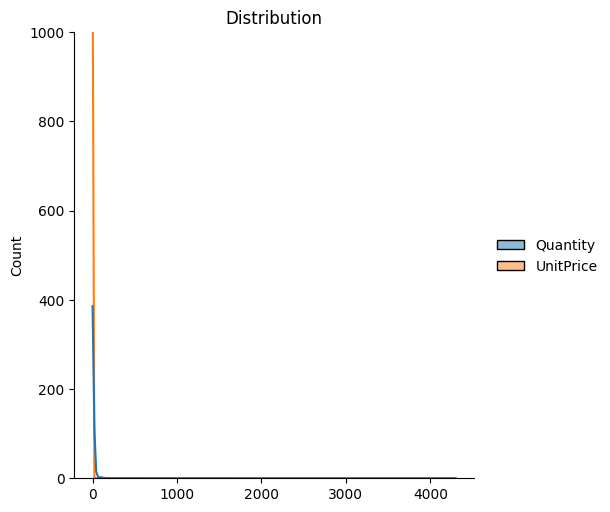

In [19]:
# Look at the distribution of 'Quantity' and 'UnitPrice' values
sample = df_sales.select('Quantity', 'UnitPrice').sample(False, 0.1).toPandas()
plt.figure(figsize=(5, 5))
sns.displot(sample, kde=True)
plt.title("Distribution")
plt.ylim([0, 1000])
plt.show()

<Figure size 500x500 with 0 Axes>

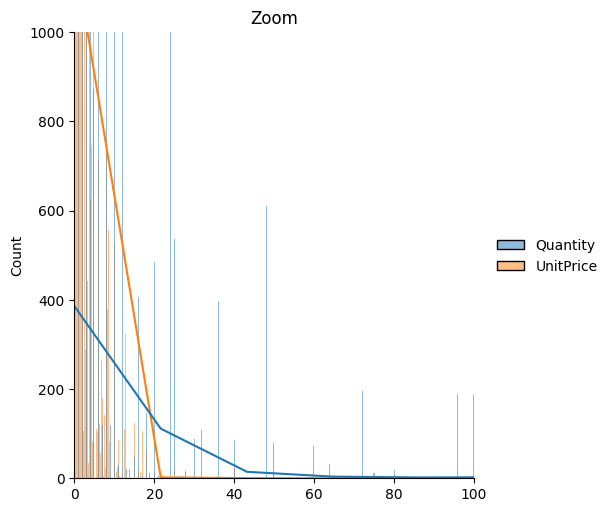

In [20]:
# Zoom
plt.figure(figsize=(5, 5))
sns.displot(sample, kde=True)
plt.title("Zoom")
plt.xlim([0, 100])
plt.ylim([0, 1000])
plt.show()

<Axes: >

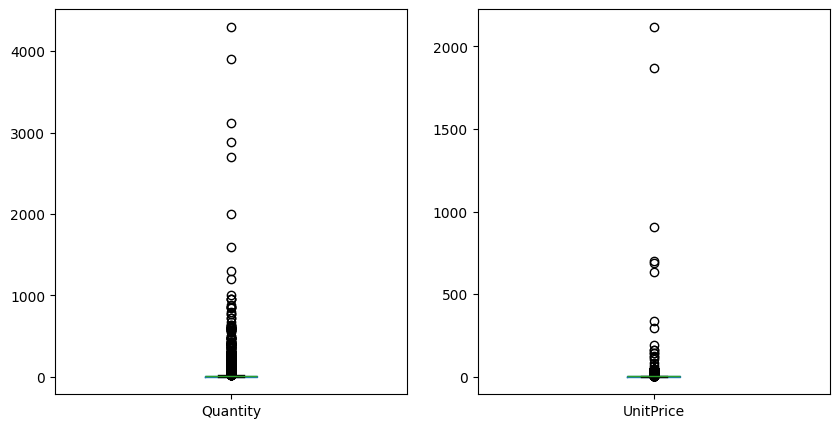

In [22]:
# Detect outliers using Box plots
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
sample.boxplot(['Quantity'], grid=False)
ax2 = plt.subplot(122)
sample.boxplot(['UnitPrice'], grid=False)

In [23]:
# Filter outliers based on interquartile range (IQR) method
for column in ['Quantity', 'UnitPrice']:
    quantiles = df_sales.approxQuantile(column, [0.25, 0.75], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1
    lower_bound = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    df_sales = df_sales.filter((col(column)>=lower_bound) & (col(column)<=upper_bound))

<Axes: >

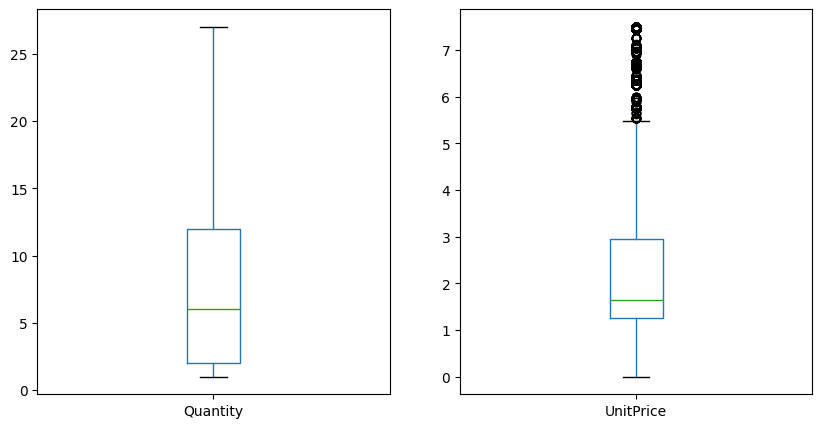

In [24]:
# Box plots after removing outliers
sample = df_sales.select('Quantity', 'UnitPrice').toPandas()
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
sample.boxplot(['Quantity'], grid=False)
ax2 = plt.subplot(122)
sample.boxplot(['UnitPrice'], grid=False)

In [25]:
df_sales.count()

338182

It may be useful to use the experts' insights to clarify whether these outliers indicate a special situation or an error, and to separately investigate how they may affect the results, but this step is skipped for now.


In [26]:
# Check StockCode
df_sales.select('StockCode').distinct().count()

3395

In [27]:
df_sc = df_sales.select('StockCode').distinct().orderBy('StockCode')
df_sc.tail(10)

[Row(StockCode='90214T'),
 Row(StockCode='90214U'),
 Row(StockCode='90214V'),
 Row(StockCode='90214W'),
 Row(StockCode='90214Y'),
 Row(StockCode='90214Z'),
 Row(StockCode='BANK CHARGES'),
 Row(StockCode='M'),
 Row(StockCode='PADS'),
 Row(StockCode='POST')]

In [28]:
# Filter out irrelevant codes
irrelevant_codes = [row['StockCode'] for row in df_sc.tail(4)]
df_sales = df_sales.filter(~col('StockCode').isin(irrelevant_codes))

#### Manage data types

In [30]:
# Convert InvoiceDate to datetime
df_sales = \
df_sales.withColumn("InvoiceDate",\
                    sf.to_date(sf.to_timestamp(col("InvoiceDate"), "dd-MM-yyyy HH:mm")))
df_sales.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Country: string (nullable = true)



In [31]:
# Adding desired features
df_sales = df_sales.withColumn('Year', sf.year('InvoiceDate')).\
                    withColumn('Month', sf.month('InvoiceDate')).\
                    withColumn('Week', sf.weekofyear('InvoiceDate')).\
                    withColumn('Day', sf.dayofmonth('InvoiceDate')).\
                    withColumn('DayofWeek', sf.dayofweek('InvoiceDate'))
df_sales.show(5)

+----------+---------+---------+--------------------+--------+-----------+---------+--------------+----+-----+----+---+---------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|       Country|Year|Month|Week|Day|DayofWeek|
+----------+---------+---------+--------------------+--------+-----------+---------+--------------+----+-----+----+---+---------+
|     17420|   536385|    22961|JAM MAKING SET PR...|      12| 2010-12-01|     1.45|United Kingdom|2010|   12|  48|  1|        4|
|     17420|   536385|    22960|JAM MAKING SET WI...|       6| 2010-12-01|     4.25|United Kingdom|2010|   12|  48|  1|        4|
|     17420|   536385|    22663|JUMBO BAG DOLLY G...|      10| 2010-12-01|     1.95|United Kingdom|2010|   12|  48|  1|        4|
|     17420|   536385|   85049A|TRADITIONAL CHRIS...|      12| 2010-12-01|     1.25|United Kingdom|2010|   12|  48|  1|        4|
|     17420|   536385|    22662|LUNCH BAG DOLLY G...|      10| 2010-12-01|     1.65|United

In [33]:
# Exporting processed data
path = "data/"
df_sales.write.option("header", True)\
             .option("delimiter", ",")\
             .mode("overwrite")\
             .csv(path + "OnlineRetail_Processed.csv")

## **Part 2: Modeling**


In [34]:
# Load data
path = "data/"
df_sales = spark.read.csv(path + "OnlineRetail_Processed.csv",
                          header=True, inferSchema=True, sep=",")
df_sales.show(5)

+----------+---------+---------+--------------------+--------+-----------+---------+--------------+----+-----+----+---+---------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|       Country|Year|Month|Week|Day|DayofWeek|
+----------+---------+---------+--------------------+--------+-----------+---------+--------------+----+-----+----+---+---------+
|     17420|   536385|    22961|JAM MAKING SET PR...|      12| 2010-12-01|     1.45|United Kingdom|2010|   12|  48|  1|        4|
|     17420|   536385|    22960|JAM MAKING SET WI...|       6| 2010-12-01|     4.25|United Kingdom|2010|   12|  48|  1|        4|
|     17420|   536385|    22663|JUMBO BAG DOLLY G...|      10| 2010-12-01|     1.95|United Kingdom|2010|   12|  48|  1|        4|
|     17420|   536385|   85049A|TRADITIONAL CHRIS...|      12| 2010-12-01|     1.25|United Kingdom|2010|   12|  48|  1|        4|
|     17420|   536385|    22662|LUNCH BAG DOLLY G...|      10| 2010-12-01|     1.65|United

#### Prepare our data for modeling purpose and split it into training and testing sets

In [36]:
# Aggregate data
df_group_sales = \
df_sales.groupBy('Country', 'StockCode', 'InvoiceDate',\
                  'Year', 'Month', 'Day', 'Week', 'DayOfWeek', 'UnitPrice')\
                  .agg(sf.sum('Quantity').alias('Quantity'))

Assemble the features to one vector

In [40]:
country_indexer = StringIndexer(inputCol="Country", outputCol="Country_indexed", handleInvalid='skip')
stockCode_indexer = StringIndexer(inputCol="StockCode", outputCol="StockCode_indexed", handleInvalid='skip')
assembler = VectorAssembler(inputCols=[country_indexer.getOutputCol(),\
                                       stockCode_indexer.getOutputCol(),\
                                       'Year', 'Month', 'Day', 'Week', 'DayOfWeek', 'UnitPrice'],\
                             outputCol='Features', handleInvalid='skip')
pl = Pipeline(stages=[country_indexer, stockCode_indexer, assembler])
df_group_sales = pl.fit(df_group_sales).transform(df_group_sales)

Splitting data into training and testing sets


In [41]:
training_data = df_group_sales.filter(df_group_sales.InvoiceDate <= "2011-10-01")
testing_data = df_group_sales.filter(df_group_sales.InvoiceDate > "2011-10-01")

#### Decision Tree Regression

In [42]:
dt = DecisionTreeRegressor(featuresCol='Features', labelCol='Quantity',\
                           predictionCol="Quantity_predicted", maxBins=4000,\
                           maxDepth=5)
dt_model = dt.fit(training_data)
dt_preds = dt_model.transform(testing_data)

#### Random Forest Regression

In [43]:
rfr = RandomForestRegressor(featuresCol='Features', labelCol='Quantity',\
                      predictionCol="Quantity_predicted", maxBins=4000,\
                            maxDepth=5)
rfr_model = rfr.fit(training_data)
rfr_preds = rfr_model.transform(testing_data)

#### Gradient Boosted Trees


In [44]:
gbt = GBTRegressor(featuresCol='Features', labelCol='Quantity',\
                   predictionCol="Quantity_predicted", maxBins=4000,\
                   maxDepth=5, stepSize=0.1, maxIter=20)
gbt_model = gbt.fit(training_data)
gbt_preds = gbt_model.transform(testing_data)

#### Evaluation

In [45]:
evaluator_mae = RegressionEvaluator(labelCol='Quantity',\
                                    predictionCol='Quantity_predicted',\
                                    metricName='mae')
models = {'Decision Tree Regression': dt_preds,
          'Random Forest Regression': rfr_preds,
          'Gradient Boosted Trees': gbt_preds}
mae = {}
print("Mean Absolute Error (MAE) on test data")
for model_name, preds in models.items():
    mae[model_name] = round(evaluator_mae.evaluate(preds), 2)
df_mae= spark.createDataFrame(mae.items(), "Model: string, MAE: double")
df_mae.show()

Mean Absolute Error (MAE) on test data
+--------------------+----+
|               Model| MAE|
+--------------------+----+
|Decision Tree Reg...| 8.5|
|Random Forest Reg...|8.24|
|Gradient Boosted ...|9.75|
+--------------------+----+



#### Plotting prediction results for comparision

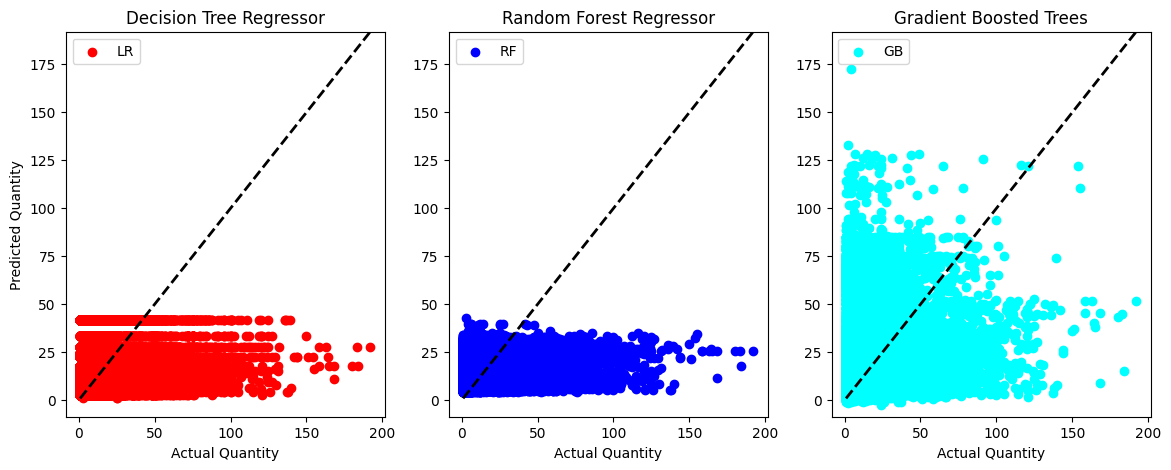

In [47]:
x = dt_preds.select("Quantity").rdd.flatMap(list).collect()
y_dt = dt_preds.select("Quantity_predicted").rdd.flatMap(list).collect()
y_rf = rfr_preds.select("Quantity_predicted").rdd.flatMap(list).collect()
y_gb = gbt_preds.select("Quantity_predicted").rdd.flatMap(list).collect()

plt.figure(figsize=(14, 5))

# Decision Tree Regressor
ax1 = plt.subplot(131)
plt.scatter(x, y_dt, color='red', label='LR')
plt.plot([min(x), max(x)], [min(x), max(x)], '--k', lw=2)
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')
plt.title('Decision Tree Regressor')
plt.ylim(top=max(x))
plt.legend()

# Random Forest Regressor
ax2 = plt.subplot(132, sharey=ax1)
plt.scatter(x, y_rf, color='blue', label='RF')
plt.plot([min(x), max(x)], [min(x), max(x)], '--k', lw=2)
plt.xlabel('Actual Quantity')
plt.title('Random Forest Regressor')
plt.legend()

# Gradient Boosted Trees
plt.subplot(133, sharey=ax1)
plt.scatter(x, y_gb, color='cyan', label='GB')
plt.plot([min(x), max(x)], [min(x), max(x)], '--k', lw=2)
plt.xlabel('Actual Quantity')
plt.title('Gradient Boosted Trees')
plt.legend()
plt.show()

You may want to tune the hyperparameters of these models to improve their performance. You may also want to explore further preprocessing and feature engineering and pay attention to factors that may affect demands such as seasnoality, etc.

Save the models

In [48]:
dt_model.save("DT_model")
rfr_model.save("RFR_model")
gbt_model.save("GBT_model")

In [14]:
# Stop Spark session
spark.stop()